Rosita Raišuotytė 2016026 ["Deer", "Car", "Helicopter"]

In [1]:
import torch
from pandas.core.common import flatten
import numpy as np

from PIL import Image
from typing import Tuple, Dict, List

import glob
import re

import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

# Nuotraukų parsisiuntimas naudojantis openimages

In [3]:
pip install openimages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 112.9 MB/s eta 0:00:00


In [4]:
import os
from openimages.download import download_dataset

In [5]:
data_dir = "OpenImages"

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

number_for_samples = 2000
classes = ['Deer', 'Car', 'Helicopter']

In [6]:
print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_for_samples)

100%|██████████| 177/177 [00:11<00:00, 15.24it/s]


{'deer': {'images_dir': 'OpenImages/deer/images'},
 'car': {'images_dir': 'OpenImages/car/images'},
 'helicopter': {'images_dir': 'OpenImages/helicopter/images'}}

In [7]:
def get_photo_paths(data_path):
  image_paths = []
  image_paths_car = []
  image_paths_deer = []
  image_paths_helicopter = []

  for data_path in glob.glob(data_path + '/*'):
    paths = glob.glob(data_path + '/images/*')
    print(data_path, ' ', len(paths))

    for photo_path in paths:
      if re.search(".*car", photo_path):
        image_paths_car.append(photo_path)
      if re.search(".*deer", photo_path):
        image_paths_deer.append(photo_path) 
      if re.search(".*helicopter", photo_path):
        image_paths_helicopter.append(photo_path)  
    
  return list(flatten(image_paths_car)), list(flatten(image_paths_deer)), list(flatten(image_paths_helicopter)) 

In [8]:
image_paths_car, image_paths_deer, image_paths_helicopter = get_photo_paths(data_dir)
image_classes = ['deer', 'car', 'helicopter']

split_1 = int(0.8 * len(image_paths_car))
split_2 = int(0.9 * len(image_paths_car))
train_filenames_car = image_paths_car[:split_1]
test_filenames_car = image_paths_car[split_2:]

split_1 = int(0.8 * len(image_paths_deer))
split_2 = int(0.9 * len(image_paths_deer))
train_filenames_deer = image_paths_deer[:split_1]
test_filenames_deer = image_paths_deer[split_2:]

split_1 = int(0.8 * len(image_paths_helicopter))
split_2 = int(0.9 * len(image_paths_helicopter))
train_filenames_helicopter = image_paths_helicopter[:split_1]
test_filenames_helicopter = image_paths_helicopter[split_2:]

image_paths_train = train_filenames_car + train_filenames_deer + train_filenames_helicopter
image_paths_test = test_filenames_car + test_filenames_deer + test_filenames_helicopter

print(len(image_paths_train))
print(len(image_paths_test))

OpenImages/helicopter   1067
OpenImages/car   2000
OpenImages/deer   937
3202
401


# Nuotraukų parsisiuntimas naudojantis downloadOI.py

In [ ]:
import os

In [ ]:
# Download required meta-files
!wget https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv
 
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
 
!wget https://storage.googleapis.com/openimages/2018_04/validation/validation-annotations-bbox.csv
 
!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv

In [ ]:
!pip install awscli

In [ ]:
!python3 downloadOI.py --classes "Deer,Car,Helicopter" --mode train

In [ ]:
!python3 downloadOI.py --classes "Deer,Car,Helicopter" --mode test

# Nuotraukų kelių gavimas parsisiuntus naudojantis downloadOI.py

In [ ]:
import torch
from pandas.core.common import flatten
import numpy as np

from PIL import Image
from typing import Tuple, Dict, List

import glob
import re

In [ ]:
def get_photo_paths(data_path):
  image_paths = []
  for data_path in glob.glob(data_path + '/*'):
    paths = glob.glob(data_path + '/*')
    print(data_path, ' ', len(paths))

    for photo_path in paths:
      if re.search(".*jpg$", photo_path):
        image_paths.append(photo_path)
    
  return list(flatten(image_paths))

In [ ]:
image_classes = ['Deer', 'Car', 'Helicopter']
data_dir = '/content'

image_paths_train = get_photo_paths(data_dir + "/train")
image_paths_test = get_photo_paths(data_dir + "/test")

/content/train/Deer   4186
/content/train/Giraffe   1840
/content/train/Elephant   3464
/content/test/Deer   560
/content/test/Giraffe   94
/content/test/Elephant   272


# Gpu/cpu device

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda:0


# Transformacijos

In [9]:
from torchvision import transforms

In [10]:
transforms_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# transforms_train = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])

transforms_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),    
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Dataset

In [11]:
from torch.utils.data import Dataset

In [12]:
class MyDataset(Dataset):

   def __init__(self, image_paths, transform=True):
        self.image_paths = image_paths
        self.transform = transform
        
   def __len__(self):
        return len(self.image_paths)

   def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)
        if image.mode is not 'RGB':
            image = image.convert('RGB')
        image = self.transform(image)
        
        label = image_filepath.split('/')[1]  #[3]
        label = class_to_idx[label]
        
        return image, label

# Dataloader

In [13]:
from torch.utils.data import DataLoader

In [14]:
num_workers = 2
batch_size = 16

# Modelis

In [64]:
class MyModel1(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes
    
    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 32, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(64 * (in_shape[1] // (2*2)) * (in_shape[2] // (2*2)), 224)
    self.fc2 = torch.nn.Linear(224, 128)
    self.fc3 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        torch.nn.ReLU(),
        self.fc2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y

# Epoch: 30, Time: 59m33s, Training loss: 0.12069132666344481
# Training accuracy: 97.41, Validation accuracy: 89.03    

In [ ]:
class MyModel2(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes
    
    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 32, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(64 * (in_shape[1] // (2*2)) * (in_shape[2] // (2*2)), 224)
    self.fc2 = torch.nn.Linear(224, 224)
    self.fc3 = torch.nn.Linear(224, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        torch.nn.ReLU(),
        self.fc2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y

# Epoch: 20, Time: 41m42s, Training loss: 0.1866034850899816
# Training accuracy: 93.44, Validation accuracy: 87.03    

In [33]:
class MyModel3(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes
    
    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 64, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(64, 128, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(128 * (in_shape[1] // (2*2)) * (in_shape[2] // (2*2)), 516)
    self.fc2 = torch.nn.Linear(516, 224)
    self.fc3 = torch.nn.Linear(224, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        torch.nn.ReLU(),
        self.fc2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y

# Epoch: 10, Time: 20m9s, Training loss: 0.1964600879411718
# Training accuracy: 94.82, Validation accuracy: 85.79       

In [ ]:
class MyModel4(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes
    
    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 64, (7, 7), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(64, 128, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(128 * (in_shape[1] // (2*2)) * (in_shape[2] // (2*2)), 224)
    self.fc2 = torch.nn.Linear(224, 128)
    self.fc3 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        torch.nn.ReLU(),
        self.fc2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y  

# Epoch: 30, Time: 31m03s, Training loss: 0.14508988153127447
# Training accuracy: 95.72, Validation accuracy: 83.54    

In [ ]:
class MyModel5(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes
    
    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 32, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.conv3_1 = torch.nn.Conv2d(64, 128, (3, 3), padding = 'same')
    self.conv3_2 = torch.nn.Conv2d(128, 128, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(128 * (in_shape[1] // (2*2*2)) * (in_shape[2] // (2*2*2)), 516)
    self.fc2 = torch.nn.Linear(516, 224)
    self.fc3 = torch.nn.Linear(224, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv3_1,
        torch.nn.ReLU(),
        self.conv3_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        torch.nn.ReLU(),
        self.fc2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y

# Epoch: 31, Time: 65m17s, Training loss: 0.10236165500639789
# Training accuracy: 97.0, Validation accuracy: 86.53    

In [ ]:
class MyModel6(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes
    
    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 16, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(16, 16, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(16, 32, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.conv3_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.conv3_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(64 * (in_shape[1] // (2*2*2)) * (in_shape[2] // (2*2*2)), 224)
    self.fc2 = torch.nn.Linear(224, 128)
    self.fc3 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv3_1,
        torch.nn.ReLU(),
        self.conv3_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        torch.nn.ReLU(),
        self.fc2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y

# Epoch: 30, Time: 1h0m5s, Training loss: 0.1601044990224254
# Training accuracy: 95.35, Validation accuracy: 85.79    

# Mokymo ir testavimo funkcijos

In [21]:
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime

In [22]:
def train_one_epoch(model, loader, loss_func, optimizer):
  loss_acum = []
  classes = model.num_classes

  model.train()
  
  for data in loader:
    images = data[0].to(device)
    labels = torch.nn.functional.one_hot(data[1], classes).float().to(device)

    pred = model(images)
    loss = loss_func(pred, labels)
    loss_acum = np.append(loss_acum, loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return np.mean(loss_acum)

In [23]:
def train_all_epochs(model, loader, epoch_count = 15, lr = 1e-3):
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  start_time = datetime.now()

  train_accuracy_acum = []
  valid_accuracy_acum = []

  for epoch in range(epoch_count):
    loss_avr = train_one_epoch(model, loader, loss_fn, optimizer)

    # evaluation
    train_accuracy = evaluate_while_training(model, loader_train)
    train_accuracy_acum.append(train_accuracy)
    valid_accuracy = evaluate_while_training(model, loader_test)
    valid_accuracy_acum.append(valid_accuracy)

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'Epoch: {epoch}, Time: {elapsed}, Training loss: {loss_avr}')
    print(f'  Training accuracy: {np.round(train_accuracy * 100, 2)}, Validation accuracy: {np.round(valid_accuracy * 100, 2)}')

  return train_accuracy_acum, valid_accuracy_acum

In [24]:
def evaluate(model, loader):
  model.eval()

  ground_truth = []
  predictions = []

  for data in loader:
    images = data[0].to(device)
    labels = data[1]

    with torch.no_grad():
      output = model(images)
      
    pred_label = torch.argmax(output, axis = 1)
    predictions = np.append(predictions, pred_label.cpu().detach())
    ground_truth = np.append(ground_truth, labels)

  return predictions, ground_truth 

In [25]:
def evaluate_while_training(model, loader):
  predictions, ground_truth = evaluate(model, loader)
  correct_predictions = np.sum(predictions == ground_truth)
  total_predictions = ground_truth.size
  accuracy = correct_predictions / total_predictions
  
  return accuracy

# Confusion matrix

In [26]:
def create_confusion_matrix(predictions, ground_truth):
  matrix = {}
  matrix['00'] = np.sum(np.bitwise_and(ground_truth == 0, predictions == 0))
  matrix['01'] = np.sum(np.bitwise_and(ground_truth == 0, predictions == 1))
  matrix['02'] = np.sum(np.bitwise_and(ground_truth == 0, predictions == 2))
  matrix['10'] = np.sum(np.bitwise_and(ground_truth == 1, predictions == 0))
  matrix['11'] = np.sum(np.bitwise_and(ground_truth == 1, predictions == 1))
  matrix['12'] = np.sum(np.bitwise_and(ground_truth == 1, predictions == 2))
  matrix['20'] = np.sum(np.bitwise_and(ground_truth == 2, predictions == 0))
  matrix['21'] = np.sum(np.bitwise_and(ground_truth == 2, predictions == 1))
  matrix['22'] = np.sum(np.bitwise_and(ground_truth == 2, predictions == 2))

  return matrix

In [27]:
pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from tabulate import tabulate

In [29]:
def print_class_matrix(matrix):

  data = [['0', matrix['TN'], matrix['FP']], 
          ['1', matrix['FN'], matrix['TP']]]

  print(tabulate(data, headers = ['True/Pred', '0', '1'], tablefmt = 'fancy_grid'))

In [30]:
def print_confusion_matrix(matrix):
  data = [['Deer', matrix['00'], matrix['01'], matrix['02']], 
         ['Car', matrix['10'], matrix['11'], matrix['12']], 
         ['Helicopter', matrix['20'], matrix['21'], matrix['22']]]

  print(tabulate(data, headers = ['True/Pred', 'Deer', 'Car', 'Helicopter'], tablefmt = 'fancy_grid'))

# Metrikų skaičiavimas

In [31]:
def calculate_confusion_matrix_by_class(ground_truth, predictions, class_idx):
  matrix = {}
  matrix['TP'] = np.sum(np.bitwise_and(ground_truth == class_idx, predictions == class_idx))
  matrix['TN'] = np.sum(np.bitwise_and(ground_truth == predictions, predictions != class_idx)) # groud true lygu prediction bet nelygu klasei
  matrix['FP'] = np.sum(np.bitwise_and(ground_truth != class_idx, predictions == class_idx))
  matrix['FN'] = np.sum(np.bitwise_and(ground_truth == class_idx, predictions != class_idx))

  return matrix

In [32]:
def calculate_metrics(matrix):
  TP = matrix['TP']
  TN = matrix['TN']
  FP = matrix['FP']
  FN = matrix['FN']

  metrics = {}
  metrics['accuracy'] = (TP + TN) / (TP + FP + TN + FN)
  metrics['recall'] = TP / (TP + FN)
  metrics['precision'] = TP / (TP + FP)
  metrics['f1'] = 2 * (metrics['recall'] * metrics['precision']) / (metrics['recall'] + metrics['precision'])

  return metrics

# Veikimas ir skaičiavimai

In [34]:
dataset_train = MyDataset(image_paths_train, transforms_train)
dataset_test = MyDataset(image_paths_test, transforms_test)

In [35]:
loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True, num_workers = num_workers)
loader_test = DataLoader(dataset_test, batch_size = batch_size, shuffle=False, num_workers = num_workers)

Parameter count: 67,862,727
Epoch: 0, Time: 2m7s, Training loss: 0.7788318612089205
  Training accuracy: 77.95, Validation accuracy: 76.56
Epoch: 1, Time: 4m9s, Training loss: 0.5776749422301107
  Training accuracy: 78.2, Validation accuracy: 80.8
Epoch: 2, Time: 6m10s, Training loss: 0.5148737595152499
  Training accuracy: 83.01, Validation accuracy: 80.8
Epoch: 3, Time: 8m12s, Training loss: 0.4814926912146273
  Training accuracy: 77.67, Validation accuracy: 82.29
Epoch: 4, Time: 10m14s, Training loss: 0.4416010108086007
  Training accuracy: 85.38, Validation accuracy: 84.54
Epoch: 5, Time: 12m16s, Training loss: 0.42132431196410264
  Training accuracy: 85.92, Validation accuracy: 84.04
Epoch: 6, Time: 14m19s, Training loss: 0.40166354541717775
  Training accuracy: 85.85, Validation accuracy: 82.54
Epoch: 7, Time: 16m21s, Training loss: 0.3762625096671617
  Training accuracy: 85.95, Validation accuracy: 78.05
Epoch: 8, Time: 18m25s, Training loss: 0.3544962070140969
  Training accura

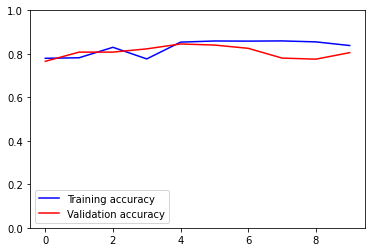

In [36]:
model = MyModel3(dataset_train[0][0].shape, 3).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

train_acc, valid_acc = train_all_epochs(model, loader_train, epoch_count = 10, lr = 1e-3)
plot_accuracy(train_acc, valid_acc)

Parameter count: 14,775,043
Epoch: 0, Time: 2m3s, Training loss: 0.7351398890587821
  Training accuracy: 77.83, Validation accuracy: 76.81
Epoch: 1, Time: 4m4s, Training loss: 0.5817321541149225
  Training accuracy: 75.39, Validation accuracy: 76.06
Epoch: 2, Time: 6m6s, Training loss: 0.5135177257493954
  Training accuracy: 83.35, Validation accuracy: 80.55
Epoch: 3, Time: 8m8s, Training loss: 0.48958098284195906
  Training accuracy: 83.26, Validation accuracy: 81.8
Epoch: 4, Time: 10m10s, Training loss: 0.4547984316685603
  Training accuracy: 85.23, Validation accuracy: 82.79
Epoch: 5, Time: 12m12s, Training loss: 0.4342363477865262
  Training accuracy: 83.67, Validation accuracy: 83.79
Epoch: 6, Time: 14m14s, Training loss: 0.4265951639161774
  Training accuracy: 83.07, Validation accuracy: 77.56
Epoch: 7, Time: 16m17s, Training loss: 0.4190088932527535
  Training accuracy: 87.54, Validation accuracy: 84.54
Epoch: 8, Time: 18m20s, Training loss: 0.3862730506714897
  Training accurac

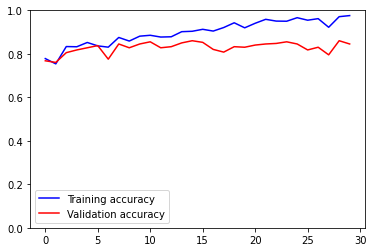

In [65]:
model1 = MyModel1(dataset_train[0][0].shape, 3).to(device)
print(f'Parameter count: {sum(p.numel() for p in model1.parameters() if p.requires_grad):,}')

train_acc1, valid_acc1 = train_all_epochs(model1, loader_train, epoch_count = 30, lr = 1e-3)
plot_accuracy(train_acc1, valid_acc1)

In [66]:
predictions, ground_truth = evaluate(model1, loader_test)

In [67]:
correct_predictions = np.sum(predictions == ground_truth)
total_predictions = ground_truth.size
accuracy = correct_predictions / total_predictions
print(accuracy)

0.8453865336658354


In [68]:
matrix_deer = calculate_confusion_matrix_by_class(ground_truth, predictions, class_to_idx['deer'])
matrix_car = calculate_confusion_matrix_by_class(ground_truth, predictions, class_to_idx['car'])
matrix_helicopter = calculate_confusion_matrix_by_class(ground_truth, predictions, class_to_idx['helicopter'])

matrix_all = {}
matrix_all['TP'] = matrix_deer['TP'] + matrix_car['TP'] + matrix_helicopter['TP']
matrix_all['TN'] = matrix_deer['TN'] + matrix_car['TN'] + matrix_helicopter['TN']
matrix_all['FP'] = matrix_deer['FP'] + matrix_car['FP'] + matrix_helicopter['FP']
matrix_all['FN'] = matrix_deer['FN'] + matrix_car['FN'] + matrix_helicopter['FN']

metrics_deer = calculate_metrics(matrix_deer)
metrics_car = calculate_metrics(matrix_car)
metrics_helicopter = calculate_metrics(matrix_helicopter)
metrics_all = calculate_metrics(matrix_all)

In [69]:
matrix = create_confusion_matrix(predictions, ground_truth)
print_confusion_matrix(matrix)

╒═════════════╤════════╤═══════╤══════════════╕
│ True/Pred   │   Deer │   Car │   Helicopter │
╞═════════════╪════════╪═══════╪══════════════╡
│ Deer        │     76 │    11 │            7 │
├─────────────┼────────┼───────┼──────────────┤
│ Car         │      3 │   184 │           13 │
├─────────────┼────────┼───────┼──────────────┤
│ Helicopter  │      6 │    22 │           79 │
╘═════════════╧════════╧═══════╧══════════════╛


In [70]:
print('Deer matrix')
print_class_matrix(matrix_deer)
print('Car matrix')
print_class_matrix(matrix_car)
print('Helicopter matrix')
print_class_matrix(matrix_helicopter)
print('All matrix')
print_class_matrix(matrix_all)

Deer matrix
╒═════════════╤═════╤═════╕
│   True/Pred │   0 │   1 │
╞═════════════╪═════╪═════╡
│           0 │ 263 │   9 │
├─────────────┼─────┼─────┤
│           1 │  18 │  76 │
╘═════════════╧═════╧═════╛
Car matrix
╒═════════════╤═════╤═════╕
│   True/Pred │   0 │   1 │
╞═════════════╪═════╪═════╡
│           0 │ 155 │  33 │
├─────────────┼─────┼─────┤
│           1 │  16 │ 184 │
╘═════════════╧═════╧═════╛
Helicopter matrix
╒═════════════╤═════╤═════╕
│   True/Pred │   0 │   1 │
╞═════════════╪═════╪═════╡
│           0 │ 260 │  20 │
├─────────────┼─────┼─────┤
│           1 │  28 │  79 │
╘═════════════╧═════╧═════╛
All matrix
╒═════════════╤═════╤═════╕
│   True/Pred │   0 │   1 │
╞═════════════╪═════╪═════╡
│           0 │ 678 │  62 │
├─────────────┼─────┼─────┤
│           1 │  62 │ 339 │
╘═════════════╧═════╧═════╛


In [71]:
print_metrics(metrics_deer, class_to_idx['deer'])
print_metrics(metrics_car, class_to_idx['car'])
print_metrics(metrics_helicopter, class_to_idx['helicopter'])
print_all_metrics(metrics_all)

Class  deer  metrics:
  accuracy :  0.9262295081967213
  recall :  0.8085106382978723
  precision :  0.8941176470588236
  f1 :  0.8491620111731844

Class  car  metrics:
  accuracy :  0.8737113402061856
  recall :  0.92
  precision :  0.847926267281106
  f1 :  0.882494004796163

Class  helicopter  metrics:
  accuracy :  0.875968992248062
  recall :  0.7383177570093458
  precision :  0.797979797979798
  f1 :  0.766990291262136

All   metrics:
  accuracy :  0.8913234005258545
  recall :  0.8453865336658354
  precision :  0.8453865336658354
  f1 :  0.8453865336658354


In [73]:
print(get_image_label(model, 'https://media.npr.org/assets/img/2021/11/10/white-tailed-deer-1-ac07593f0b38e66ffac9178fb0c787ca75baea3d.jpg'))

deer


# Papildomos funkcijos

In [59]:
def get_image_label(model, url):
  model.eval()
  image = Image.open(requests.get(url, stream=True).raw)
  # response = requests.get(url)
  # image = Image.open(BytesIO(response.content))
  image = transforms_test(image)
  output = model(image.unsqueeze(0).to(device))
  pred_label = torch.argmax(output, axis = 1)

  return idx_to_class[pred_label.item()]

In [16]:
# Pagalbinės funkcijos verčiant pavadinimą (label) į indeksą
idx_to_class = {i:j for i, j in enumerate(image_classes)}
class_to_idx = {value:key for key, value in idx_to_class.items()}
print(idx_to_class)
print(class_to_idx)

{0: 'deer', 1: 'car', 2: 'helicopter'}
{'deer': 0, 'car': 1, 'helicopter': 2}


In [17]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [18]:
def plot_accuracy(train_accuracy, valid_accuracy):
  plt.clf()
  plt.plot(train_accuracy, 'b', label = 'Training accuracy')
  plt.plot(valid_accuracy, 'r', label = 'Validation accuracy')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

In [19]:
def print_metrics(metrics, class_idx):
  print('Class ', idx_to_class[class_idx], ' metrics:')
  print('  accuracy : ', metrics['accuracy'])
  print('  recall : ', metrics['recall'])
  print('  precision : ', metrics['precision'])
  print('  f1 : ', metrics['f1'])
  print()

In [20]:
def print_all_metrics(metrics):
  print('All ', ' metrics:')
  print('  accuracy : ', metrics['accuracy'])
  print('  recall : ', metrics['recall'])
  print('  precision : ', metrics['precision'])
  print('  f1 : ', metrics['f1'])